In [62]:
import sympy as sp
from sympy.physics.mechanics import init_vprinting
from sympy import pycode

import numpy as np
import math

# Print Helpers
init_vprinting()
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))


# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Code Print Helper
def desymbolify(expr):
    
    def get_deriv_order_name(order):
        suffix = ''
        for i in range(order-1):
            suffix += 'd'
        return suffix + 'dot'
    
    # Function Mapping
    mapping = {f: sp.Symbol(f.func.__name__) for f in expr.atoms(sp.Function) | expr.atoms(sp.Function) if f.func not in (sp.sin, sp.cos)}

    # Add a mapping for Derivative objects to basic Symbol objects, including the order of the derivative
    derivatives_mapping = {d: sp.Symbol(f"{d.args[0].func.__name__}{f'_{get_deriv_order_name(d.args[1][1])}'}") for d in expr.atoms(sp.Derivative) | expr.atoms(sp.Derivative)}

    # Combine the mappings
    mapping.update(derivatives_mapping)

    # Replace Function objects with basic Symbol objects
    expr_return = expr.subs(mapping)

    # Convert the Sympy expressions to pure Python code
    return (expr_return)



In [63]:
# Compute Equations of Motion

# Constants
m_p = sp.symbols('m_p') # Pendulum Mass
m_w = sp.symbols('m_w') # Wheel Mass
I_w = sp.symbols('I_w') # Wheel Inertia
w_r =  sp.symbols('w_r') # Wheel Radius
l = sp.symbols('l') # Pendulum Length
g = sp.symbols('g') # Gravity
t = sp.symbols('t') # Time
tau_lw = sp.symbols('tau_lw') # Left Wheel Torque
tau_rw = sp.symbols('tau_rw') # Right Wheel Torque

# State Variables
x = sp.Function('x')(t) # Base Linear Position
v = sp.Function('v')(t) # Base Linear Velocity

theta = sp.Function('theta')(t) # Pendulum Angular Position
theta_dot = sp.diff(theta, t) # Pendulum Angular Velocity

# TODO: Do we want or need these states?
#phi = sp.Function('phi')(t) # Wheel Angular Position
#phi_dot = sp.diff(phi, t) # Wheel Angular Velocity

# Accelerations
v_dot = sp.diff(v, t) # Base Acceleration
theta_ddot = sp.diff(theta_dot, t) # Pundulum Angular Acceleration

# TODO: Do we want or need this acceleration?
#phi_ddot = sp.diff(phi_dot, t) # Wheel Angular Acceleration


# Intermediate Variables
x_p = sp.Function('x_p')(t) # Pendulum Mass Position (X)
z_p = sp.Function('z_p')(t) # Pendulum Mass Position (Z)

x_p_dot = sp.diff('x_p_dot', t) # Pendulum Mass Velocity (X)
z_p_dot = sp.diff('z_p_dot', t) # Pendulum Mass Velocity (Z)


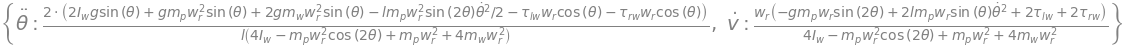

In [64]:
# Map Rotation Position/Velocity to Linear
#phi = x / w_r
#phi_dot = sp.diff(x, t)
#phi_ddot = sp.diff(x_dot, t)

# Intermediate Variables Definitions
z_p = w_r + l * sp.cos(theta) # Pendulum Mass Position (Z)

x_p_dot = v + sp.diff(l * sp.sin(theta), t) # Pendulum Mass Velocity (X) Cart Velocity + Pendulum Rotation Velocity (Derivative of Pendulum Angular POsition)
z_p_dot = sp.diff(z_p, t) # Pendulum Mass Velocity (Z)


# Langrangian Computation

# Potential Energies

U = m_p * g * z_p # Pendulum Mass Potential

# Kinetic Energies

T_lw = sp.Rational(1, 2) * m_w * (v)**2 + sp.Rational(1, 2) * I_w * (v/w_r)**2 # Left Wheel Kinetic Energy
T_rw = sp.Rational(1, 2) * m_w * (v)**2 + sp.Rational(1, 2) * I_w * (v/w_r)**2 # Right Wheel Kinetic Energy

T_w = T_lw + T_rw # Total Wheel Kinetic Energy

T_p = sp.Rational(1, 2) * m_p * (x_p_dot**2 + z_p_dot**2) # Pendulum Kinetic Energy

# Total Kinetic Energy
T = T_w + T_p

# Lagrangian
L = T - U

#d/dt (∂L/∂(dx/dt)) - ∂L/∂x = F = tau_lw/w_r + tau_rw/w_r
#d/dt (∂L/∂(dtheta/dt)) - ∂L/∂theta = 0
#d/dt (∂L/∂(dphi/dt)) - ∂L/∂phi = 0

eq_x = sp.diff(sp.diff(L, v), t) - sp.diff(L, x) - tau_lw/w_r - tau_rw/w_r
eq_theta = sp.diff(sp.diff(L, theta_dot), t) - sp.diff(L, theta)

#display(eq_x)
# TODO: Shouldn't need this
#eq_phi = sp.diff(sp.diff(L, phi_dot), t) - sp.diff(L, phi) - tau_w

display(eq_theta)
eq = [eq_x, eq_theta]
eom = sp.solve(eq, [v_dot, theta_ddot])

# Simplify
eom = sp.simplify(sp.trigsimp(eom))

display(eom)

v_dot_nofunc = desymbolify(eom[v_dot])
theta_ddot_nofunc = desymbolify(eom[theta_ddot])


#print(sp.python(x_ddot_nofunc))
#print(sp.python(theta_ddot_nofunc))


#print("V_DOT")
#print(sp.pycode(v_dot_nofunc))

#print("THETA: DDOT")
#print(sp.pycode(theta_ddot_nofunc))




In [72]:
# Linearize System

# Introduce some values
I_w_val = 0.5
g_val = 9.81
w_r_val = .1
m_p_val = 4
m_w_val = 3
l_val = .3

#I_w_val = 0.5
#g_val = 9.81
#w_r_val = 1
#m_p_val = 1
#m_w_val = 1
#l_val = 1


constants_dict = {I_w: I_w_val, w_r: w_r_val, m_p: m_p_val, m_w: m_w_val, g: g_val, l: l_val}

# Intermediate Variables
x_1 = x
x_2 = theta
x_3 = v
x_4 = theta_dot

#x_1 = theta
#x_2 = theta_dot
#x_3 = v

X_vec = sp.Matrix([x_1, x_2, x_3, x_4])
U_vec = sp.Matrix([tau_lw, tau_rw])

x_dot_sys = sp.Matrix([x_3, x_4, eom[v_dot], eom[theta_ddot]])


#display(x_dot_sys)
df_dx = x_dot_sys.jacobian(X_vec)
#display(df_dx)

# Augment with x position states
# TODO: This is kind of sucky.  Maybe a way to make the initial system 6x6 with zeroes?
# Or come up with a generic augment function to mask this BS

#df_dx = df_dx.col_insert(0, sp.Matrix([0,0,0,0]))
#df_dx = df_dx.row_insert(0, sp.Matrix([[0,0,0,0,0]]))
#df_dx = df_dx.col_insert(3, sp.Matrix([1,0,0,0,0]))
#df_dx = df_dx.row_insert(3, sp.Matrix([[0,0,0,0,0,w_r]]))
#display(df_dx)

A = df_dx.subs([(x_1, 0), (x_2, 0), (x_3, 0), (x_4, 0)])
A = sp.simplify(A)

print("Linearized Matrix A: ")
display(A)

print("Evaluated Matrix A: ")

A = A.evalf(subs=constants_dict)

# This line is a little "prettier, e.g. 0.5 = 1/2"
#A = A.subs(constants_dict)

display(A)


df_du = x_dot_sys.jacobian(U_vec)
#df_du = df_du.row_insert(0, sp.Matrix([[0]]))
#df_du = df_du.row_insert(0, sp.Matrix([[0]]))
B = df_du.subs([(tau_lw, 0), (tau_rw, 0), (x_1, 0), (x_2, 0), (x_3,0), (x_4,0)])

print("Linearized Matrix B: ")
display(B)
B = B.evalf(subs=constants_dict)

# This line is a little "prettier, e.g. 0.5 = 1/2"
#B = B.subs(constants_dict)
print("Evaluated Matrix B: ")
display(B)

print("Final X(State) Vector")
#X_vec = X_vec.row_insert(0, sp.Matrix([[sp.Function('x')(t)]]))
#X_vec = X_vec.row_insert(3, sp.Matrix([[sp.diff(sp.Function('x')(t), t)]]))
display(X_vec)


ValueError: expecting list of lists

In [73]:
# System Dynamics
def f(state, u):
 
    I_w = I_w_val
    g = g_val
    w_r = w_r_val
    m_p = m_p_val
    m_w = m_w_val
    l = l_val


    # Extract current state
    x, theta, v, theta_dot = state
    
    # Force Input
    tau_lw = u[0]
    tau_rw = u[1]
    
    
    v_dot = w_r*(-g*m_p*w_r*math.sin(2*theta) + 2*l*m_p*theta_dot**2*w_r*math.sin(theta) + 2*tau_lw + 2*tau_rw)/(4*I_w - m_p*w_r**2*math.cos(2*theta) + m_p*w_r**2 + 4*m_w*w_r**2)
    theta_ddot = 2*(2*I_w*g*math.sin(theta) + g*m_p*w_r**2*math.sin(theta) + 2*g*m_w*w_r**2*math.sin(theta) - 1/2*l*m_p*theta_dot**2*w_r**2*math.sin(2*theta) - tau_lw*w_r*math.cos(theta) - tau_rw*w_r*math.cos(theta))/(l*(4*I_w - m_p*w_r**2*math.cos(2*theta) + m_p*w_r**2 + 4*m_w*w_r**2))
    
    # TODO: Do we need this dynamic for non linear?  MIght be nice.
    #phi_ddot = (-g*m_p*w_r*math.sin(2*theta) + 2*l*m_p*theta_dot**2*w_r*math.sin(theta) + 2*tau_w)/(2*I_w - m_p*w_r**2*math.cos(2*theta) + m_p*w_r**2 + 2*m_w*w_r**2)
   
    return np.array([v, theta_dot, v_dot, theta_ddot])


# Numerical Linearization Check
# Really this needs to linearize on the NON augmented matrix, and then augment the additional states for X after
# Similar to above
def linearize(f, x0, u0, perturbation=1e-4):
    
    # Extract state and input size
    num_states = len(x0)
    num_inputs = len(u0)
    
    # System Matrix
    A = np.zeros((num_states, num_states))
    
    # Input Matrix
    B = np.zeros((num_states, num_inputs))
    
    # Initial Equilibrium Result
    f_x0 = f(x0, u0)
    
    # Linearize System Matrix
    for n in range(num_states):
        
        # Cache Eq point pre-perturb
        x_eval = x0.copy()
        
        
        # Add perturbation
        x_eval[n] += perturbation
        A[:, n] = (f(x_eval, u0) - f_x0) / perturbation
        
    
    for n in range(num_inputs):
        
        # Cache Eq point pre-perturb
        u_eval = u0.copy()
        
        
        # Add perturbation
        u_eval[n] += perturbation
        
        B[:, n] = (f(x0, u_eval) - f_x0) / perturbation
    
    
    return A, B
        

In [74]:
# Equilibirum points
x_eq = 0
v_eq = 0
theta_eq = 0
theta_dot_eq = 0

x0 = [x_eq, theta_eq, v_eq, theta_dot_eq]
u0 = [0, 0]

A, B = linearize(f=f, x0=x0, u0=u0)
print(A)
print(B)

#test = A @ np.array([0,0,0,0,0,0]) + B @ np.array([1])
#print(test)

[[ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.    -0.37   0.     0.   ]
 [ 0.    33.934  0.     0.   ]]
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.094  0.094]
 [-0.314 -0.314]]


In [75]:
# LQR Gains

import control as ct
# LQR

Q = np.eye(4) * np.array([50, 1, 5, 1])
print(Q)
R = np.eye(2) * 0.1

display(A)

# This is unstable because I am assuming that the wheel position is form -2pi to 2pi and does not accumulate.
# How can we change this so that phi(wheel position is accumulated?) or we just control x position, instead.  Or just remove both of these from the state
# And control from an outer loop for position control, i.e. only keep velocities here.


K, S, E = ct.lqr(A, B, Q, R)

display(K)
K_str = np.array2string(K, separator=', ')

print(K_str)

[[50.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  5.  0.]
 [ 0.  0.  0.  1.]]


array([[ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   , -0.37 ,  0.   ,  0.   ],
       [ 0.   , 33.934,  0.   ,  0.   ]])

array([[ -15.811, -165.144,  -19.581,  -28.619],
       [ -15.811, -165.144,  -19.581,  -28.619]])

[[ -15.811, -165.144,  -19.581,  -28.619],
 [ -15.811, -165.144,  -19.581,  -28.619]]


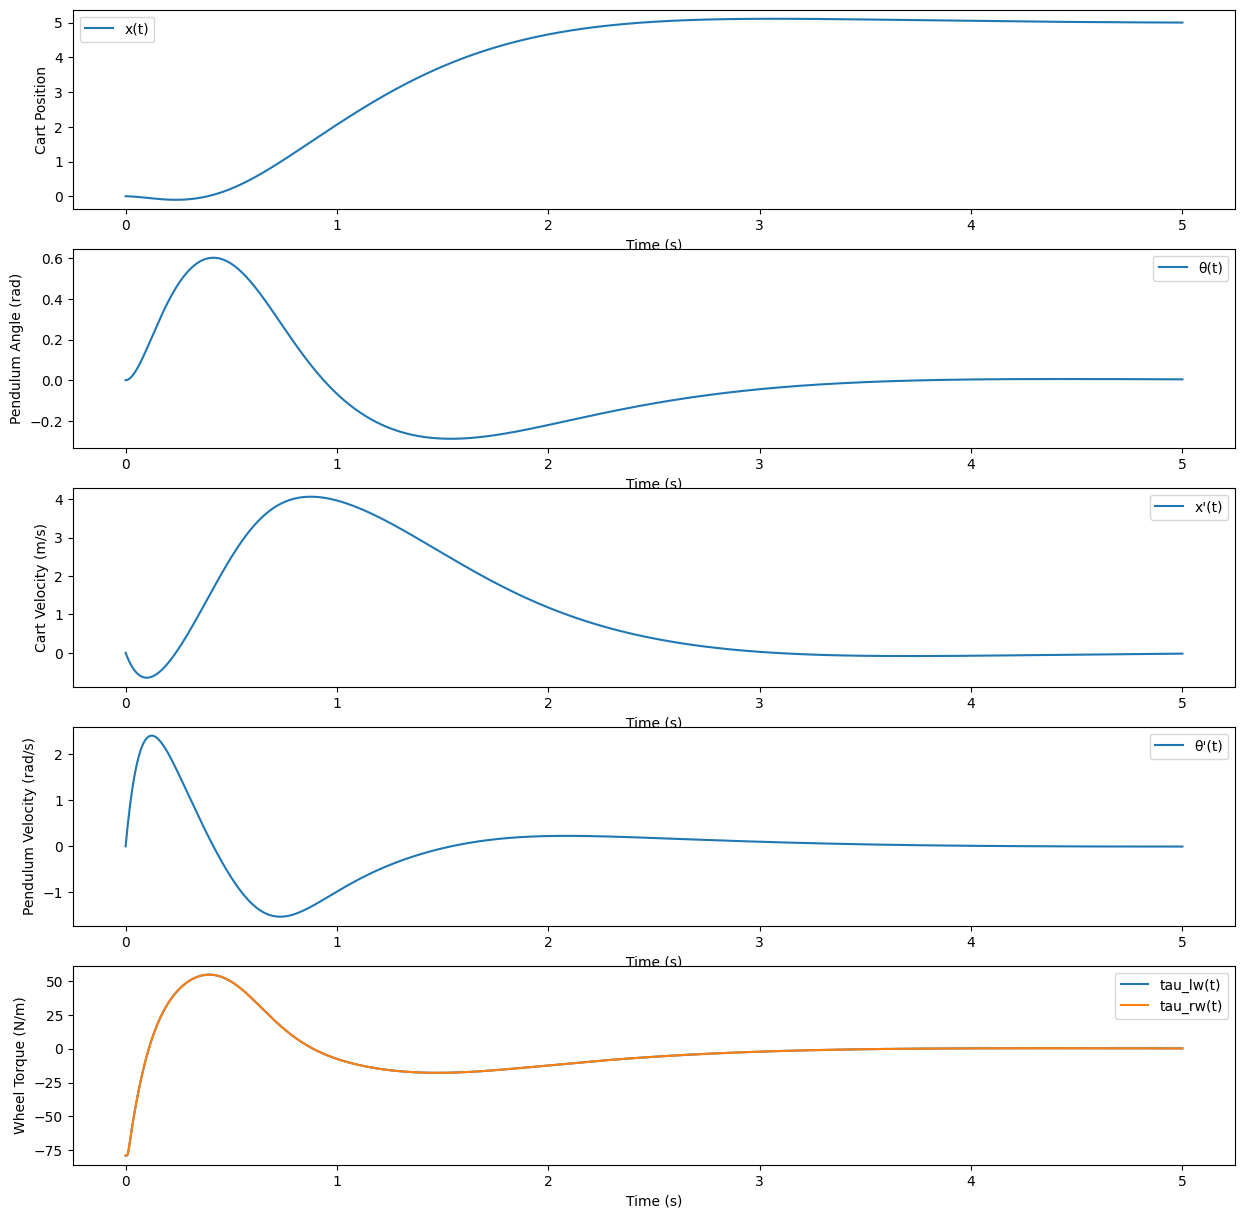

In [76]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt


I_w = I_w_val
g = g_val
w_r = w_r_val
m_p = m_p_val
m_w = m_w_val
l = l_val

u_list = []
u_list2 = []
x = np.array([0,0,0,0])
x_ref = np.array([5,0,0,0])

# Define the controller function (LQR)
def controller(t, x):
    
    # Extract current state
    #x, theta, v, theta_dot = state
    
    # LQR Control
    u = -K@(x-x_ref)
    u_list.append(u[0])
    u_list2.append(u[1])
    
    return u

# TODO: PD Controller

# TODO: PID Controller

# TODO: MPC Controller

# TODO: FUZZY Controller?

# Define the function to compute the derivatives of the state variables
def wheeled_inverted_pendulum(t, state, control_function):
    
    # Extract current state
    x, theta, v, theta_dot = state
    u = control_function(t, state)
    return f(state, u)




t_span = (0,5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
step_size = t_eval[1] - t_eval[0]

# Solve
x0 = [0,0,0,0] # Initial Conditions
result = solve_ivp(wheeled_inverted_pendulum, t_span, x0, args=(controller,), t_eval=t_eval, method='RK23', max_step=step_size, min_step=step_size)

# Reshape U.  This is annoying...  Need to do something with fixed step somehow
u_array = np.array(u_list)
u_array = interp1d(np.linspace(0, 5, len(u_list)), u_array, kind='linear')(t_eval)

u_array2 = np.array(u_list2)
u_array2 = interp1d(np.linspace(0, 5, len(u_list2)), u_array2, kind='linear')(t_eval)

# Plot the results
fig, ax = plt.subplots(5, 1, figsize=(15, 15))
ax[0].plot(result.t, result.y[0], label='x(t)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Cart Position')
ax[0].legend()

ax[1].plot(result.t, result.y[1], label='θ(t)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Pendulum Angle (rad)')
ax[1].legend()


ax[2].plot(result.t, result.y[2], label='x\'(t)')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Cart Velocity (m/s)')
ax[2].legend()

ax[3].plot(result.t, result.y[3], label='θ\'(t)')
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Pendulum Velocity (rad/s)')
ax[3].legend()

ax[4].plot(result.t, u_array, label='tau_lw(t)')
ax[4].plot(result.t, u_array2, label='tau_rw(t)')
ax[4].set_xlabel('Time (s)')
ax[4].set_ylabel('Wheel Torque (N/m)')
ax[4].legend()



plt.show()


In [ ]:
import mujoco
import mediapy as media

xml = """
<mujoco model="2d_wip">
	<compiler angle="degree" coordinate="local" />
	<option timestep="0.001" integrator="RK4" gravity="0 0 -9.81" />
	<asset>
		<texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512" />
		<texture name="body" type="cube" builtin="flat" mark="cross" width="127" height="1278" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01" />
		<material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1" />
		<texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4" />
		<material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2" />
	</asset>
	<worldbody>
		<geom name="floor" size="0 0 .05" type="plane" material="grid" condim="1" />
		<light name="spotlight" mode="targetbodycom" target="wheel" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="100" />
		<body name="wheel" pos="0 0 .1">
			<joint name="z" type="slide" pos="0 0 0" axis="0 0 1" damping="0.0" />
			<joint name="x" type="slide" pos="0 0 0" axis="1 0 0" damping="0.0" />
			<joint name="wheel_joint" type="hinge" pos="0 0 0" axis="0 1 0" damping="0.0" />
			<geom type="cylinder" euler="90 0 0" pos="0 0 0" size=".1 .01" rgba="0 1 0 1" mass="3" />
			<body name="pendulum" pos="0 0 0" euler="0 0 0">
				<joint name="pendulum_hinge" type="hinge" pos="0 0 0" axis="0 1 0" damping="0.0" />
				<geom type="cylinder" pos="0 0 .3" size="0.02 .3" rgba="1 0 0 1" mass="0" />
				<body name="pendulum_mass" pos="0 0 .3">
					<geom type="sphere" pos="0 0 .3" size="0.05" rgba="1 0 0 1" mass="4.0" />
				</body>
			</body>
		</body>
	</worldbody>
	<actuator>
		<motor joint="wheel_joint" ctrllimited="false" ctrlrange="-100 100" />
	</actuator>
</mujoco>

"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

In [ ]:
import sympy as sp

t, m_p, m_w, l, r, I_w, g, tau, theta = sp.symbols('t m_p m_w l r I_w g tau theta')
x = sp.Function('x')(t)
theta = sp.Function('theta')(t)

# Define the expressions for the equations of motion
expr_motion_x = m_p * l**2 + m_w * r**2 + I_w + 2 * m_p * l * r * sp.cos(theta)
expr_motion_theta = m_p * l * r * sp.cos(theta) + (m_p * l**2 + m_w * r**2 + I_w)

# Create a mapping from Function objects to basic Symbol objects
mapping = {f: sp.Symbol(f.func.__name__) for f in expr_motion_x.atoms(sp.Function) | expr_motion_theta.atoms(sp.Function)}

# Add a mapping for Derivative objects to basic Symbol objects, including the order of the derivative
derivatives_mapping = {d: sp.Symbol(f"{'d' * d.args[1]}{d.args[0].func.__name__}") for d in expr_motion_x.atoms(sp.Derivative) | expr_motion_theta.atoms(sp.Derivative)}

# Combine the mappings
mapping.update(derivatives_mapping)


# Replace Function and Derivative objects with basic Symbol objects
expr_motion_x_no_func_deriv = expr_motion_x.subs(mapping)
expr_motion_theta_no_func_deriv = expr_motion_theta.subs(mapping)

# Convert the Sympy expressions to pure Python code
python_code_x = sp.python(expr_motion_x_no_func_deriv)
python_code_theta = sp.python(expr_motion_theta_no_func_deriv)

print("Python code for equation of motion x:")
print(python_code_x)

print("\nPython code for equation of motion theta:")
print(python_code_theta)

In [ ]:
import sympy as sp

t, m_p, m_w, l, r, I_w, g, tau, x, theta, dx, dtheta = sp.symbols('t m_p m_w l r I_w g tau x theta dx dtheta')

# Define the expressions for the equations of motion
expr_ddx = (tau - 2*m_p*l*r*dtheta**2*sp.sin(theta) + 2*m_p*g*l*sp.sin(theta)*sp.cos(theta))/(m_p*l**2 + m_w*r**2 + I_w + 2*m_p*l*r*sp.cos(theta))
expr_ddtheta = (tau*sp.cos(theta) - (m_p*l**2 + m_w*r**2 + I_w)*g*sp.sin(theta))/(m_p*l*r*sp.cos(theta) + (m_p*l**2 + m_w*r**2 + I_w))

# Define the state vector and input
state = sp.Matrix([x, theta, dx, dtheta])
input = sp.Matrix([tau])

# Compute the Jacobian matrices
A = sp.Matrix([[expr_ddx.diff(s) for s in state] for expr_ddx in (dx, dtheta, expr_ddx, expr_ddtheta)])
B = sp.Matrix([[expr_ddx.diff(u) for u in input] for expr_ddx in (dx, dtheta, expr_ddx, expr_ddtheta)])

display(A)
# Linearize the system about the equilibrium point
A_lin = A.subs({x: 0, theta: 0, dx: 0, dtheta: 0})
B_lin = B.subs({x: 0, theta: 0, dx: 0, dtheta: 0})

print("A_lin:")
display(A_lin)

print("\nB_lin:")
display(B_lin)

In [ ]:
import sympy as sp

# Original 4x4 matrix A
a11, a12, a21, a22, a31, a32, a41, a42 = sp.symbols('a11 a12 a21 a22 a31 a32 a41 a42')
A = sp.Matrix([[a11, a12, a21, a22],
               [a31, a32, a41, a42]])

# Create 2x2 zero matrix
Z2 = sp.zeros(2)

# Create 2x4 and 4x2 zero matrices
Z24 = sp.zeros(2, 4)
Z42 = sp.zeros(4, 2)

# Extend the 4x4 matrix to a 6x6 matrix
A_aug = A.row_join(Z42).col_join(Z24.row_join(Z2))

print("Augmented 6x6 matrix A_aug:")
print(A_aug)

In [ ]:


from sympy import Matrix, symbols

a11, a12, a13, a14, a21, a22, a23, a24, a31, a32, a33, a34, a41, a42, a43, a44 = symbols('a11 a12 a13 a14 a21 a22 a23 a24 a31 a32 a33 a34 a41 a42 a43 a44')

A = Matrix([
    [a11, a12, a13, a14],
    [a21, a22, a23, a24],
    [a31, a32, a33, a34],
    [a41, a42, a43, a44]
])

subset_A = A.extract([1, 3], [1, 3])
print(subset_A)


In [ ]:
from sympy import Matrix, symbols, zeros

b11, b12, b21, b22 = symbols('b11 b12 b21 b22')

B = Matrix([
    [b11, b12],
    [b21, b22]
])

expanded_matrix = zeros(4)

# Insert B matrix elements into the expanded matrix
expanded_matrix[1, 1] = B[0, 0]
expanded_matrix[1, 3] = B[0, 1]
expanded_matrix[3, 1] = B[1, 0]
expanded_matrix[3, 3] = B[1, 1]

expanded_matrix[0,0] = [10, 12, 13, 14]

display(expanded_matrix)

In [ ]:
import numpy as np

A = np.array([
    [a11, a12, a13, a14],
    [a21, a22, a23, a24],
    [a31, a32, a33, a34],
    [a41, a42, a43, a44]
])
# Replace a11, a12, ... with the actual values

subset_A = A[np.ix_([1, 2, 3], [1, 2, 3])]
print(subset_A)